<a href="https://colab.research.google.com/github/worklifesg/Computer-Vision-Algorithms-and-Projects/blob/main/6-Fine-tuning%20ResNet%20with%20Keras%2C%20TensorFlow%2C%20and%20Deep%20Learning/fine_tuning_ResNet50_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align='center'> Image Classification of Camouflage Clothes vs Normal Clothes using Fine-tuned ResNet50 </h2>

<b> Dataset: </b>

  * Around 8000 images of both camouflage and normal clothes
  * Need to split data into train/test/validation dataset

#### 1. Import Libraries

In [1]:
import os
from imutils import paths
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D,Dropout,Dense,Flatten,Input
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

from sklearn.metrics import classification_report


#### 2. Configure dataset paths and training/testing/validation dataset

In [2]:
#dataset path on google drive
dataset_path = '/content/drive/MyDrive/pyImageSearch/Datasets/archive/8k_normal_vs_camouflage_clothes_images' 

#dataset seggregation path
base_path = '/content/drive/MyDrive/pyImageSearch/Camouflage_or_NOT'

#defining the train, test, and validation dataset path (all folders are already created in the base_path before in hand)
train_path = os.path.sep.join([base_path,'training'])
test_path = os.path.sep.join([base_path,'testing'])
valid_path = os.path.sep.join([base_path,'validation'])

#defining the training split ratio of 75%
train_split = 0.75
#validation split 10%
val_split = 0.1

#there are only classes - camouflage and normal clothes
classes = ['Camouflage_Clothes','Normal_Clothes']

#intializing parameters for training
init_learning_rate = 1e-4
batch_size=32
num_epochs = 20

model_path = 'detect_cam_clothes.model' #defining the model name to save later for predictitons

#### 3. Building Dataset (Train/Test/Validation)

In [3]:
#reading the original Image paths ans shuffling them
imagePaths = list(paths.list_images(dataset_path))
random.seed(42)
random.shuffle(imagePaths)

#configuring training and testing images
i = int(len(imagePaths)*train_split)
trainPaths = imagePaths[:i] #first random 75% images
testPaths = imagePaths[i:] #rest of images left

#configuring validation dataset from training image dataset (from that 75 %)
k = int(len(trainPaths)*val_split)
valPaths = trainPaths[:k]
trainPaths = trainPaths[k:]

### Now we have 65% training, 25% testing and 10% validation dataset
# assiging the images to their respective paths

datasets = [
            ('training',trainPaths, train_path),
            ('testing',testPaths,test_path),
            ('validation',valPaths,valid_path)
]

In [4]:
###### Using the loop over datasets to extract filename and labels and copy the images to their path

for (dType,imagePaths,baseOutput) in datasets:
  #dType - data split we are creating
  #imagePaths = input image base directory
  #baseOutput = if directory is not created, we need to create it as well.

  print("Building '{}' split".format(dType))

  if not os.path.exists(baseOutput):
    print("Creating '{}' directory".format(baseOutput))
    os.makedirs(baseOutput)
  
  for inputPath in imagePaths:
    filename = inputPath.split(os.path.sep)[-1] #extract filename
    label = inputPath.split(os.path.sep)[-2] #extract label

    labelPath = os.path.sep.join([baseOutput,label]) #build the path

    if not os.path.exists(labelPath):
      print("Creating '{}' directory".format(labelPath))
      os.makedirs(labelPath)
    
    #constructing the path for destination image and then copy images

    p = os.path.sep.join([labelPath, filename])
    shutil.copy2(inputPath,p)

Building 'training' split
Creating '/content/drive/MyDrive/pyImageSearch/Camouflage_or_NOT/training/camouflage_clothes' directory
Creating '/content/drive/MyDrive/pyImageSearch/Camouflage_or_NOT/training/normal_clothes' directory
Building 'testing' split
Creating '/content/drive/MyDrive/pyImageSearch/Camouflage_or_NOT/testing/camouflage_clothes' directory
Creating '/content/drive/MyDrive/pyImageSearch/Camouflage_or_NOT/testing/normal_clothes' directory
Building 'validation' split
Creating '/content/drive/MyDrive/pyImageSearch/Camouflage_or_NOT/validation/normal_clothes' directory
Creating '/content/drive/MyDrive/pyImageSearch/Camouflage_or_NOT/validation/camouflage_clothes' directory


#### 4. Training Dataset using fine-tuned ResNet50

In [5]:
#total number of training, testing and validation files

totalTrain = len(list(paths.list_images(train_path)))
totalTest = len(list(paths.list_images(test_path)))
totalValid = len(list(paths.list_images(valid_path)))

print('Training: ', totalTrain)
print('Testing: ', totalTest)
print('Validation: ',totalValid)

Training:  10731
Testing:  3975
Validation:  1192


In [7]:
#intializing training image augmentation
'''
Data augmentation allows for training time mutations of our images including random rotations, 
zooms, shifts, shears, flips, and mean subtraction.
'''
train_aug = ImageDataGenerator(
    rotation_range = 25,
    zoom_range =0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#for testing/validation augmentation
val_aug = ImageDataGenerator()

### For ImageNet neam subtration in RGB order for each of the image augmentation object

mean=np.array([123.68,116.779,103.939],dtype='float32')
train_aug.mean=mean
val_aug.mean=mean

In [8]:
###### GENERATORS for DATASETS ########

train_gen = train_aug.flow_from_directory(
    train_path,class_mode='categorical',target_size=(224,224),
    color_mode='rgb',shuffle=True,batch_size=batch_size)

test_gen = val_aug.flow_from_directory(
    test_path,class_mode='categorical',target_size=(224,224),
    color_mode='rgb',shuffle=False,batch_size=batch_size)

val_gen = val_aug.flow_from_directory(
    valid_path,class_mode='categorical',target_size=(224,224),
    color_mode='rgb',shuffle=False,batch_size=batch_size)

Found 10731 images belonging to 2 classes.
Found 3975 images belonging to 2 classes.
Found 1192 images belonging to 2 classes.


In [11]:
##### Creating Fine-Tuned ResNet50 deep learning architecture #####

base_model = ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

new_head_model = base_model.output
new_head_model = AveragePooling2D(pool_size=(7,7))(new_head_model)
new_head_model = Flatten()(new_head_model)
new_head_model = Dense(256,activation='relu')(new_head_model)
new_head_model = Dropout(0.5)(new_head_model)
new_head_model = Dense(len(classes),activation='softmax')(new_head_model)

model = Model(inputs=base_model.input,outputs=new_head_model)

#We want to train (fine-tune) only head of the network and make sure the weigths of the base of CNN are FROZEN
#Fine tuning means performing network surgery so that we can froze the as input weigths and train the new head and then unfroze it to train it fully.

for layer in base_model.layers:
  layer.trainable = False

#intializing optimizer and compiling it

opt = Adam(lr=init_learning_rate,decay=init_learning_rate/num_epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [12]:
###### training the network

H = model.fit_generator(
    train_gen,
    steps_per_epoch=totalTrain // batch_size,
    validation_data=val_gen,
    validation_steps=totalValid // batch_size,
    epochs=num_epochs
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
335/335 [==============================] - 322s 942ms/step - loss: 0.3269 - accuracy: 0.8634 - val_loss: 0.0672 - val_accuracy: 0.9797
Epoch 2/20
335/335 [==============================] - 311s 927ms/step - loss: 0.0994 - accuracy: 0.9632 - val_loss: 0.0523 - val_accuracy: 0.9840
Epoch 3/20
335/335 [==============================] - 307s 918ms/step - loss: 0.0735 - accuracy: 0.9764 - val_loss: 0.0459 - val_accuracy: 0.9823
Epoch 4/20
335/335 [==============================] - 308s 921ms/step - loss: 0.0700 - accuracy: 0.9750 - val_loss: 0.0445 - val_accuracy: 0.9848
Epoch 5/20
335/335 [==============================] - 307s 915ms/step - loss: 0.0596 - accuracy: 0.9811 - val_loss: 0.0392 - val_accuracy: 0.9873
Epoch 6/20
335/335 [==============================] - 305s 911ms/step - loss: 0.0469 - accuracy: 0.9857 - val_loss: 0.0415 - val_accuracy: 0.9848
Epoch 7/20
335/335 [==============================] - 309s 921ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0363 -

#### 5. Making Predictions

In [13]:
test_gen.reset() #resetting the testing generator to make sure nothing is predicted on it before

predIdxs = model.predict_generator(test_gen,steps=(totalTest//batch_size)+1) #making predictions

#find the index of the label with corresponding largest predictibility

predIdxs = np.argmax(predIdxs,axis=1)

print(classification_report(test_gen.classes,predIdxs,
                            target_names=test_gen.class_indices.keys()))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


                    precision    recall  f1-score   support

camouflage_clothes       0.99      0.98      0.99      1968
    normal_clothes       0.98      0.99      0.99      2007

          accuracy                           0.99      3975
         macro avg       0.99      0.99      0.99      3975
      weighted avg       0.99      0.99      0.99      3975



In [14]:
#saving the model.h5 file

model.save(model_path,save_format='h5')

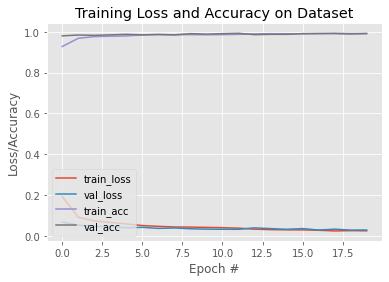

In [15]:
############### Plot training loss accuracy and accuracy on dataset
N = num_epochs

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

plt.legend(loc="lower left")
plt.savefig('plot.png')